## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score,confusion_matrix,mean_squared_error,mean_absolute_error
from tensorflow.keras import losses
import tensorflow.keras as tfk
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers import Dense,Conv2D,Conv1D,AveragePooling2D,MaxPool2D,BatchNormalization,Dropout,Flatten

## Data Handling    
    1. image name contains age gender and ethencity of a person
    2. Extracting features and creating dataframe for data preprocessing

In [ ]:
df = pd.DataFrame(columns=['image','age','gender']) # Dataframe creation
x= 0
for i in os.listdir('UTKFace'):
    try:
        split = i.split('_')
        gender = int(split[1]) # parsing from image name 
        ages = int(split[0])
        image = Image.open('UTKFace\\' + i)
        image = image.resize((110,110))
        image = np.array(image).astype(np.float32)/255.0
        df.loc[x] = [image,ages,gender] # storing data
        x += 1
    except:
        continue 


In [ ]:
df = df.sample(frac=1).reset_index(drop=True) # shuffling data 

In [9]:
df.head()

,image,age,gender
0,"[[[0.019607844, 0.02745098, 0.015686275], [0.0...",26,1
1,"[[[0.29803923, 0.2627451, 0.24313726], [0.1725...",25,1
2,"[[[0.06666667, 0.03529412, 0.023529412], [0.09...",29,0
3,"[[[0.83137256, 0.90588236, 0.95686275], [0.831...",45,0
4,"[[[0.12156863, 0.11372549, 0.1254902], [0.1333...",25,0


26 1


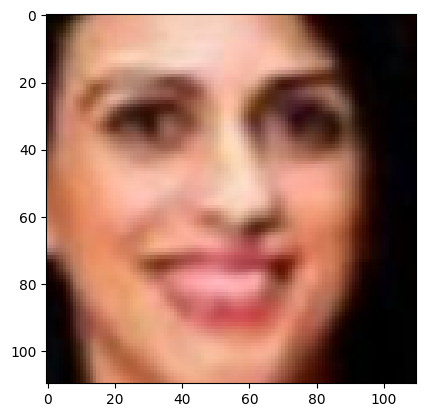

In [10]:
plt.imshow(df['image'][0])
print(df['age'][0],df['gender'][0])

This data not distributed properly by visual representation below it shows that  comparing  to others,
age range between 25 to 35 contains more number of data  so we have to maintain equal level or closer to equal level in data distribution

<Axes: xlabel='age', ylabel='count'>

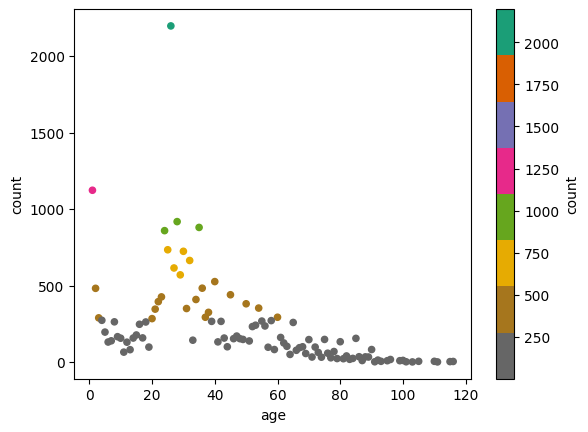

In [ ]:
df['age'].value_counts().reset_index().plot(x='age',y = 'count',kind='scatter',c='count',colormap='Dark2_r') #plotting

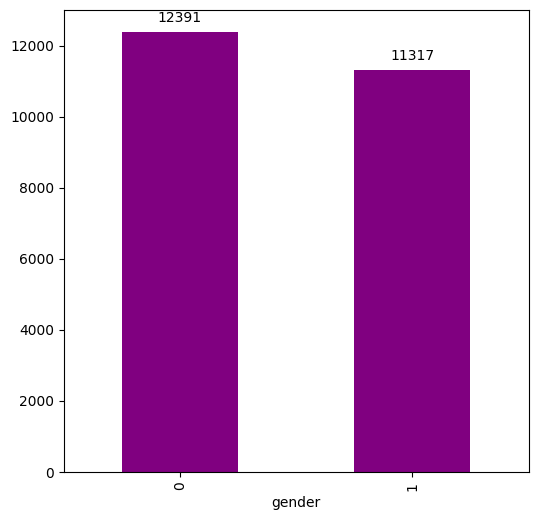

In [ ]:
age_count = df['gender'].value_counts().reset_index() #seperating data based on gender
ref = age_count.plot(x='gender',y = 'count',kind='bar',color='Purple',legend=None,figsize=(6,6))

for p in ref.patches:
     ref.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', 
                xytext=(0, 5), textcoords='offset points')

In [ ]:
age_range = [i for i in range(25,35)]
e = 0
filters = df[(df['age'].isin(age_range))&(df['gender'].isin([0,1]))] # reducing volume of age range between 25 and 35 
kf = df[~((df['age'].isin(age_range))&(df['gender'].isin([0,1])))] 
kf1 = filters.sample(frac=0.3).reset_index(drop=True) # shuffling and sampling
org = pd.concat([kf,kf1],axis=0) # concating data
filters.shape,kf1.shape,org.shape

((7324, 3), (2197, 3), (18581, 3))

By removing value using sample method now it is looks better for model performance

<Axes: xlabel='age', ylabel='count'>

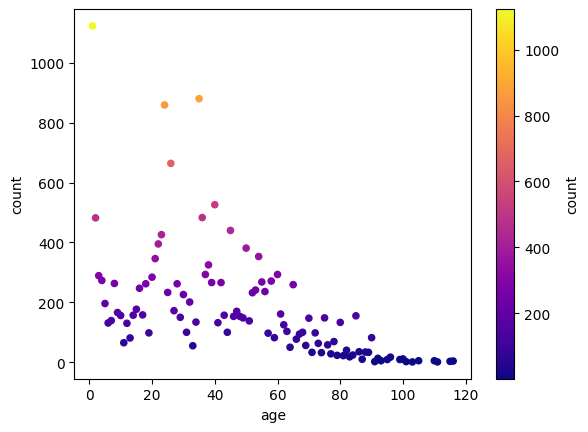

In [14]:
org['age'].value_counts().reset_index().plot(x='age',y = 'count',kind='scatter',c='count',colormap='plasma')

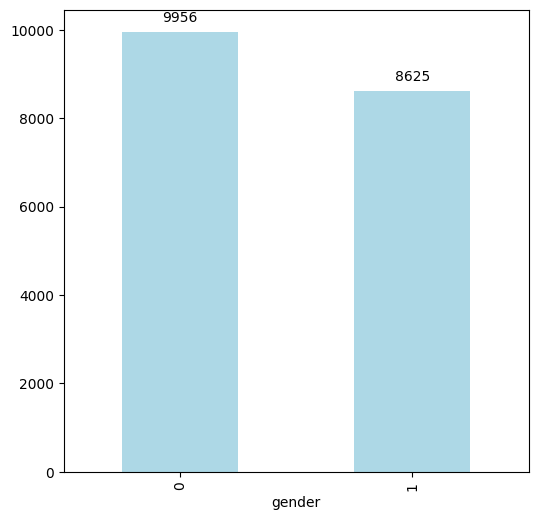

In [ ]:
age_count = org['gender'].value_counts().reset_index()
ref = age_count.plot(x='gender',y = 'count',kind='bar',color='lightblue',legend=None,figsize=(6,6))

for p in ref.patches:
     ref.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', 
                xytext=(0, 5), textcoords='offset points') # showing value over bar graph

In [ ]:
x = np.concatenate(org['image'].__array__()) # Extracting image from dataframe
x = x.reshape(-1,110,110,3)

In [ ]:
y = np.array([org['gender'].values,org['age'].values])
y = y.T
print(y)
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=60,test_size=0.3)# splitting data for model input and evaluation
x_train.shape,x_test.shape,y_train.shape,y_test.shape

[[ 0 45]
 [ 0  9]
 [ 0 38]
 ...
 [ 0 28]
 [ 0 30]
 [ 0 26]]


((13006, 110, 110, 3), (5575, 110, 110, 3), (13006, 2), (5575, 2))

In [18]:
y_train = [y_train[:,0],y_train[:,1]]
y_test = [y_test[:,0],y_test[:,1]]
y_train

[array([1, 1, 1, ..., 0, 1, 1]), array([ 1, 76, 24, ..., 52,  4, 95])]

## Model Development
    1. Image dimension is 110,110,3 we have to  enhance the model performance by deciding proper filters and pooling method using appropriate strides. 
    2. First cnn layer contains 35 filters, max pooling method, normalize the features, dropout a certain amount of neurons to avoid overfitting.
    3. second cnn layer contains 75 filters with 3X3 stride layer.
    4. Third cnn layer contains 165 and fourth layer contains 425 cnn filters.
    5. Each and every layer using RELU as activation function.
    6. After flattening building Neural network with three hidden layers (1000,1000,100) and RELU is activation function for each layer
        2 layer for output (2,1) for classification output activation function is sigmoid and regression output has no activation function.
    7. we are predicting  continious value and classification values so we are using MAE(mean absolute error) loss function for continious and 
    Binary_crossentropy loss function for classification value
    

In [ ]:
def build(input_shape):
    input = tfk.Input(input_shape)
   
    con = Conv2D(35,(3,3),activation='relu')(input)
    pool = MaxPool2D((2,2),padding='valid')(con)
    batch = BatchNormalization()(pool)
    drop = Dropout(0.3)(batch)
    
    con = Conv2D(75,(3,3),activation='relu')(drop)
    pool = MaxPool2D((3,3),padding='same')(con)
    batch = BatchNormalization()(pool)
    drop = Dropout(0.3)(batch)

    con = Conv2D(165,(3,3),activation='relu')(drop)
    pool = MaxPool2D((2,2),padding='same')(con)
    batch = BatchNormalization()(pool)
    drop = Dropout(0.2)(batch)
    
    con = Conv2D(425,(3,3),activation='relu')(drop)
    pool = MaxPool2D((2,2),padding='same')(con)
    batch = BatchNormalization()(pool)
    drop = Dropout(0.2)(batch)
    
    flat = Flatten()(drop)
    dense = Dense(1000,activation = 'relu')(flat)
    dense = BatchNormalization()(dense)
    
    dense = Dense(1000,activation='relu')(dense)
    dense = BatchNormalization()(dense)
    
    dense = Dense(100,activation='relu')(dense)
    dense = BatchNormalization()(dense)
    
    out = Dense(1,activation='sigmoid',name='gender')(dense)
    out2 = Dense(1,name='age')(dense)
    
    model = tfk.Model(inputs=input,outputs=[out,out2])
    model.compile(loss=["binary_crossentropy","mae"],optimizer="Adam",metrics=["accuracy",'mae'])
    return model

In [47]:
model = build((110,110,3))
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 110, 110,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 108, 108,  │        980 │ input_layer_3[0]… │
│                     │ 35)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 54, 54,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 35)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        140 │ max_pooling2d_6[… │
│ (BatchNormalizatio… │ 35)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 54, 54,    │          0 │ batch_normalizat… │
│                     │ 35)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 52, 52,    │     23,700 │ dropout_6[0][0]   │
│                     │ 75)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 18, 18,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 75)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 18, 18,    │        300 │ max_pooling2d_7[… │
│ (BatchNormalizatio… │ 75)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 18, 18,    │          0 │ batch_normalizat… │
│                     │ 75)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │    111,540 │ dropout_7[0][0]   │
│                     │ 165)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 8, 8, 165) │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 165) │        660 │ max_pooling2d_8[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 8, 8, 165) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 6, 6, 425) │    631,550 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 3, 3, 425) │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 3, 425) │      1,700 │ max_pooling2d_9[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 3, 3, 425) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 3825)      │          0 │ dropout_9[0][0] 

 Total params: 5,706,272 (21.77 MB)

 Trainable params: 5,700,672 (21.75 MB)

 Non-trainable params: 5,600 (21.88 KB)

## Callbacks
    1. Model check point to monitor validation loss to get better model to export
    2. setting threshold to stop when there is no improvement in model prediction to avoid underfitting early stopping is important

In [48]:
modelfile='Age_gender.keras'
checkp=ModelCheckpoint(modelfile,monitor='val_loss',
                       verbose=1,save_best_only=True,
                       save_weights_only=False,
                       mode='auto',
                       save_freq='epoch')
threshold=EarlyStopping(patience=50,monitor='val_loss',
                                           restore_best_weights='True',
                                           start_from_epoch = 10)

In [49]:
history = model.fit(x_train,y_train,
          batch_size=14,
                validation_data=(x_test,y_test),
                epochs=200,
                shuffle = True,
                steps_per_epoch=len(x_train) // 18,
                callbacks=[checkp,threshold])

model.summary()

Epoch 1/200
  9/722 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - age_mae: 33.4210 - gender_accuracy: 0.6202 - loss: 34.3621  

I0000 00:00:1730789874.358955     257 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_reduce_window_fusion_4', 4 bytes spill stores, 4 bytes spill loads



719/722 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - age_mae: 27.6817 - gender_accuracy: 0.6835 - loss: 28.3102
Epoch 1: val_loss improved from inf to 11.65908, saving model to Age_gender.keras
722/722 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - age_mae: 27.6416 - gender_accuracy: 0.6836 - loss: 28.2699 - val_age_mae: 11.0896 - val_gender_accuracy: 0.7148 - val_loss: 11.6591
Epoch 2/200
206/722 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - age_mae: 12.2169 - gender_accuracy: 0.6639 - loss: 12.8177

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 11.65908
722/722 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - age_mae: 11.7855 - gender_accuracy: 0.6787 - loss: 12.3741 - val_age_mae: 12.4963 - val_gender_accuracy: 0.7275 - val_loss: 13.0358
Epoch 3/200
718/722 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - age_mae: 10.8629 - gender_accuracy: 0.7105 - loss: 11.4176
Epoch 3: val_loss improved from 11.65908 to 11.53193, saving model to Age_gender.keras
722/722 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - age_mae: 10.8611 - gender_accuracy: 0.7105 - loss: 11.4158 - val_age_mae: 11.0404 - val_gender_accuracy: 0.7672 - val_loss: 11.5319
Epoch 4/200
202/722 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - age_mae: 9.8708 - gender_accuracy: 0.7630 - loss: 10.3625
Epoch 4: val_loss did not improve from 11.53193
722/722 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - age_mae: 9.8783 - gender_accuracy: 0.7605 - loss: 10.3710 - val_age_mae: 11.1425 - val_gender_accuracy: 0.7849 - val_loss: 11.5994
Epoch 5/200
721/722 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - age_ma

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 110, 110,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 108, 108,  │        980 │ input_layer_3[0]… │
│                     │ 35)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 54, 54,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 35)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        140 │ max_pooling2d_6[… │
│ (BatchNormalizatio… │ 35)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 54, 54,    │          0 │ batch_normalizat… │
│                     │ 35)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 52, 52,    │     23,700 │ dropout_6[0][0]   │
│                     │ 75)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 18, 18,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 75)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 18, 18,    │        300 │ max_pooling2d_7[… │
│ (BatchNormalizatio… │ 75)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 18, 18,    │          0 │ batch_normalizat… │
│                     │ 75)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │    111,540 │ dropout_7[0][0]   │
│                     │ 165)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 8, 8, 165) │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 165) │        660 │ max_pooling2d_8[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 8, 8, 165) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 6, 6, 425) │    631,550 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 3, 3, 425) │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 3, 425) │      1,700 │ max_pooling2d_9[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 3, 3, 425) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 3825)      │          0 │ dropout_9[0][0] 

 Total params: 17,107,618 (65.26 MB)

 Trainable params: 5,700,672 (21.75 MB)

 Non-trainable params: 5,600 (21.88 KB)

 Optimizer params: 11,401,346 (43.49 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step
54 45


/tmp/ipykernel_30/3087550359.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f'actual:{y_test[0][i]},predicted:{int(predicted[0][0] >0.5)}')


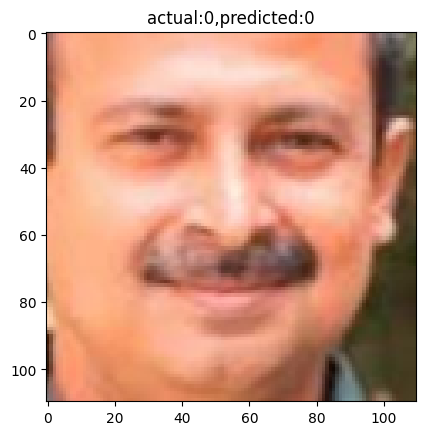

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
54 26


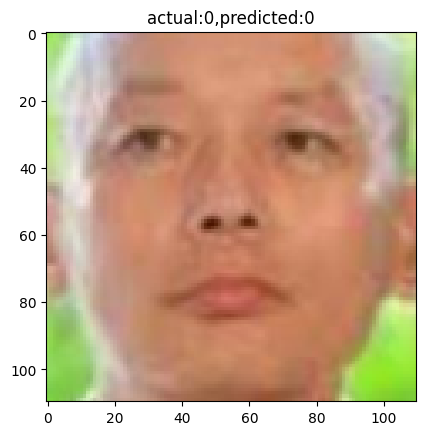

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
72 78


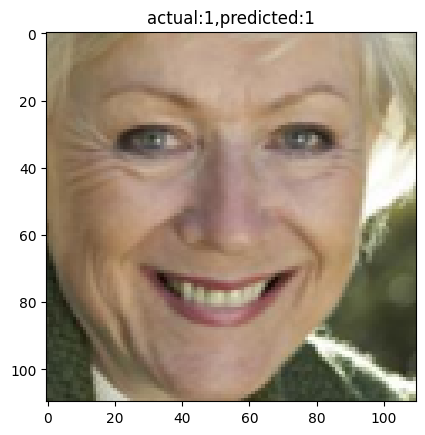

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
80 48


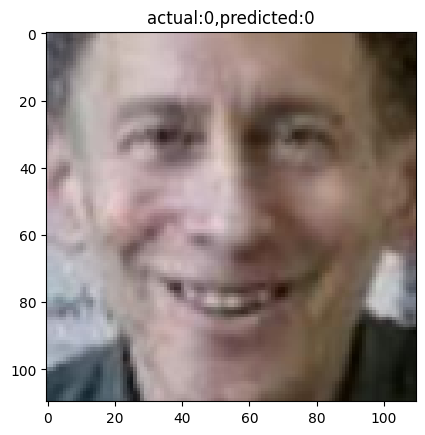

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
55 48


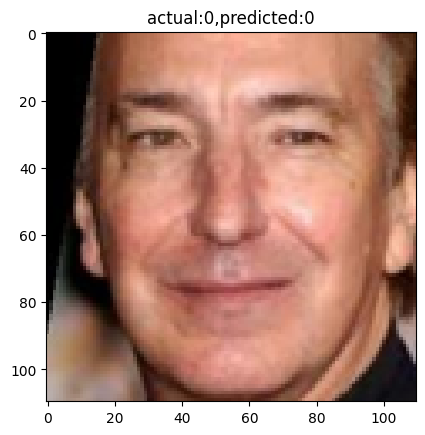

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
89 76


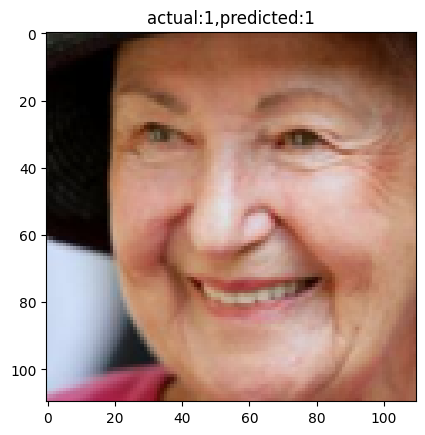

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
48 48


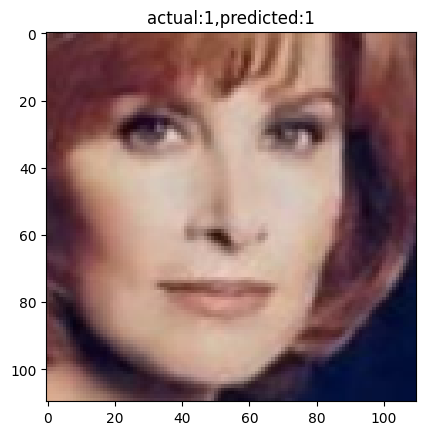

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3 0


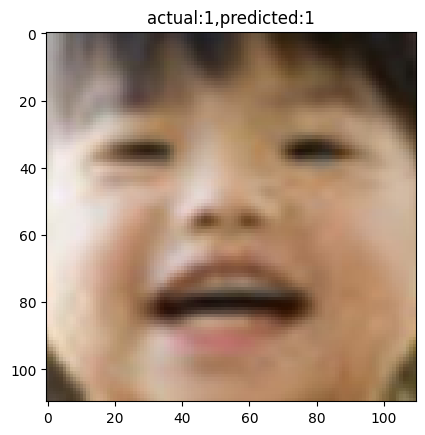

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
45 35


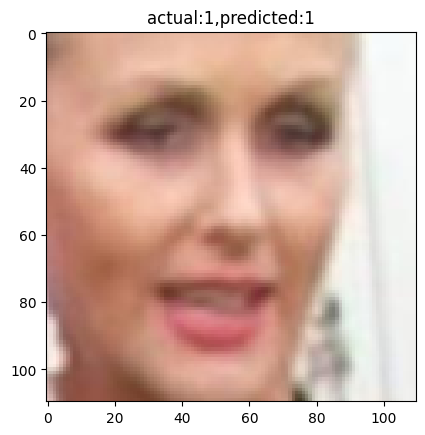

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
32 39


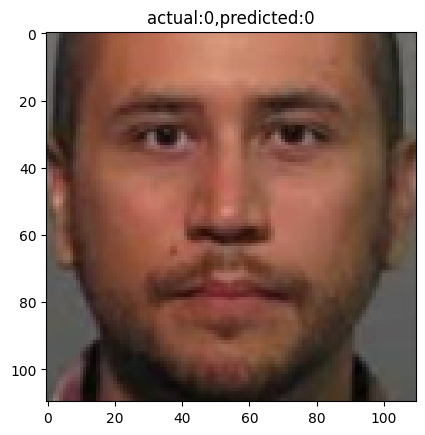

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
58 60


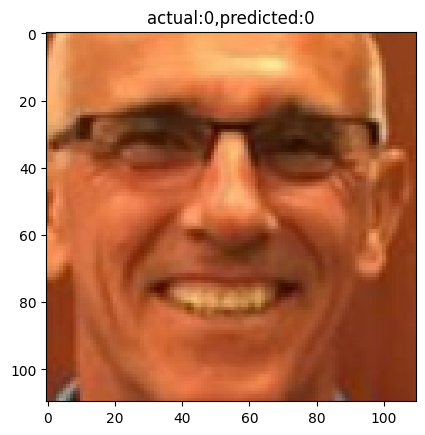

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
53 52


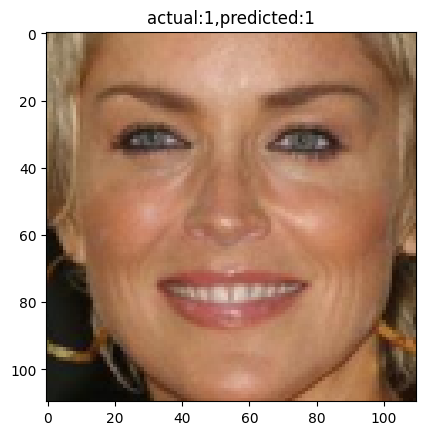

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
10 14


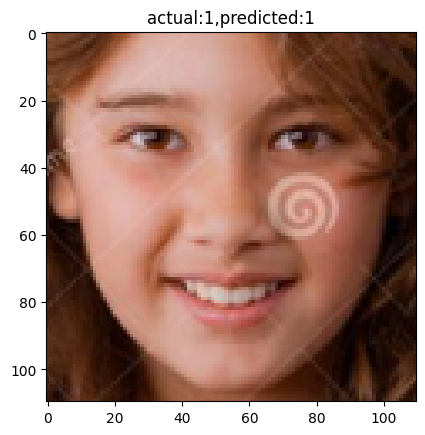

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
28 47


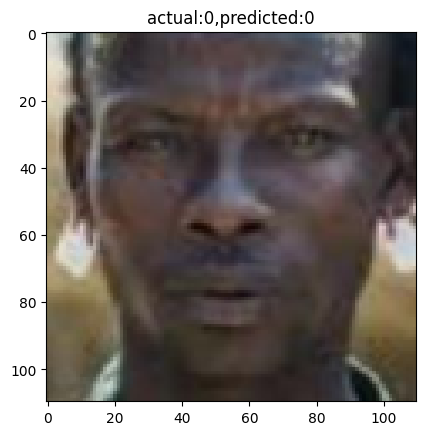

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1 2


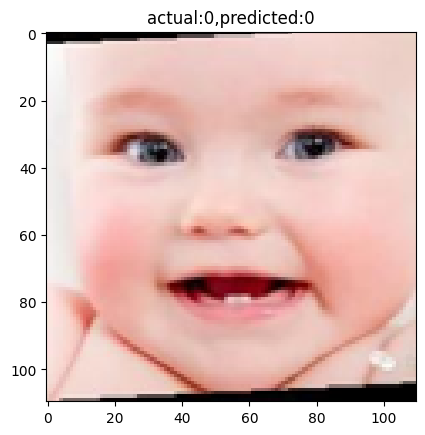

In [50]:
for i in range(15):
    plt.imshow(x_test[i])
    test = np.expand_dims(x_test[i],axis=0)
    predicted =  model.predict(test) 
    plt.title(f'actual:{y_test[0][i]},predicted:{int(predicted[0][0] >0.5)}')
    print(y_test[1][i],round(predicted[1][0][0]))
    plt.show()

Early stopping and model checkpoint plays important role to findout correct time to stop the model to avoid overfitting. By visual representation given below the model stopped when it starts to overfit.

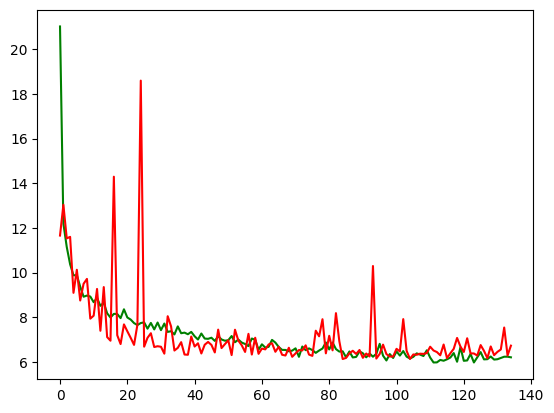

In [51]:
history1 = history.history
loss = history1['loss']
val_loss = history1['val_loss']
plt.plot(loss,c='green')
plt.plot(val_loss,c='red')
plt.show()

In [52]:
y_pred = model.predict(x_test)
y_pred1 = y_pred[0]
ypred_2 = y_pred[1]

175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


## Model Evaluation
    Model evaluation is an essential part of the machine learning process that helps assess how well a model performs on a given dataset.
    This involves metrics that measure the accuracy of the model's predictions compared to the actual values.
    1. Confusion Matrix:
        [ 
True Negative (TN)
False Positive (FP)
​
  
False Negative (FN)
True Positive (TP)
​
 ]

    2. Accuracy
    3. Mean Squared Error
    4. Mean Absolute Error

In [53]:
print('confusion matrix: ',confusion_matrix(y_test[0],y_pred1>0.5))
print('accuracy: ', accuracy_score(y_test[0],y_pred1>0.5))

confusion matrix:  [[2702  367]
 [ 272 2234]]
accuracy:  0.8853811659192825


In [54]:
print('mse: ',mean_squared_error(y_test[1],np.round(ypred_2)))
print('mae: ' ,mean_absolute_error(y_test[1],np.round(ypred_2)))

mse:  71.83156950672645
mae:  5.858834080717489
